# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment


In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe", no_graphics = False)
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Build and train the model

A multi-agent DDPG algorithm is used in this implementation. Two agents each having an actor-critic neural network will share the replay buffer and learn from joint experiences. Both actor and critic networks have local and target networks to improve the training. Specifically, two hidden layers of (512, 256) are used for the actor networks and (512, 256) for the critic networks.The critic networks use joint observations and joint actions from both agents and the actor networks use only local observations from individual agents. The learning rate for the actor and critic networks are LR_ACTOR = 1e-4 and LR_CRITIC = 1e-3, respectively. 

At the beginning of the training, we increase the exploration of the agent by adding a Gaussian noise to the actions, with an original variance of 0.5. But the variance of the noise keeps reducing till 0.1 during the training process. A decaying factor of 0.999 is applied to the variance after each episode. 

Other details:
Soft update is performed for the target network with a Tau value of 0.001.
The buffer size for the replay buffer is set to be 1e6. The training is performed in batches of 256 experiences. The rewards are discounted with gamma = 0.99.


In [2]:
TAU = 0.001
GAMMA = 0.99
LR_ACTOR = 1e-4
LR_CRITIC = 1e-3
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 256

noise_sigma = 0.5
noise_reduction = 0.999
noise_min = 0.1

n_episodes = 10000
tmax = 1000


from maddpg import MADDPG
from collections import deque

# number of agents 
num_agents = 2

MA_agent = MADDPG(num_agents, state_size=24, action_size=2, buffer_size = BUFFER_SIZE, \
                  batch_size = BATCH_SIZE, lr_actor = LR_ACTOR, lr_critic = LR_CRITIC, sigma = noise_sigma)

score_history= []
score_window = deque(maxlen = 100)

for i in range(1, n_episodes+1):
    #print(i)
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    for t in range(tmax):
        #print(t)
        actions = MA_agent.act(states, training=True)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        MA_agent.step(states, actions, rewards, next_states, dones)
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):
            break
    noise_sigma = max(noise_sigma*noise_reduction, noise_min)        
    MA_agent.update_noise(noise_sigma)
        
    score_window.append(np.max(scores))
    score_history.append(np.max(scores))
    #print(i)
    if (i%50)==0:
        print('episode {}, average score: {}, noise_sigma: {}'.format(i, np.mean(score_window), noise_sigma))
    if np.mean(score_window)>0.6:
        MA_agent.save_weights()
        break
     
        

episode 50, average score: 0.017600000277161597, noise_sigma: 0.47560281409851574
episode 100, average score: 0.0157000002451241, noise_sigma: 0.4523960735568548
episode 150, average score: 0.014600000232458115, noise_sigma: 0.43032169134151843
episode 200, average score: 0.009700000155717134, noise_sigma: 0.409324414739318
episode 250, average score: 0.0020000000298023225, noise_sigma: 0.3893516870584952
episode 300, average score: 0.0010000000149011613, noise_sigma: 0.37035351607804984
episode 350, average score: 0.0010000000149011613, noise_sigma: 0.3522823489160005
episode 400, average score: 0.006500000115484, noise_sigma: 0.33509295300337016
episode 450, average score: 0.00830000014975667, noise_sigma: 0.3187423028659689
episode 500, average score: 0.002800000049173832, noise_sigma: 0.3031894724305924
episode 550, average score: 0.0020000000298023225, noise_sigma: 0.2883955325860681
episode 600, average score: 0.004000000059604645, noise_sigma: 0.27432345374274825
episode 650, av

### Plot scores

Text(0, 0.5, 'score')

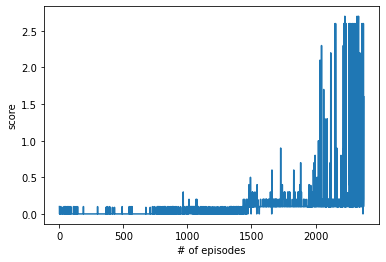

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(score_history)
plt.xlabel('# of episodes')
plt.ylabel('score')

### 3.Testing

In [10]:
from maddpg import MADDPG

agent_test = MADDPG(num_agents=2,state_size=24, action_size=2, sigma=0)
agent_test.load_weights()

env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
scores = np.zeros(agent_test.num_agents)

while True:
    actions = agent_test.act(states,training=False)        # select an action\n",
    env_info = env.step(actions)[brain_name]        # send the action to the environment\n",
    next_states = env_info.vector_observations   # get the next state\n",
    rewards = env_info.rewards                   # get the reward\n",
    dones = env_info.local_done                  # see if episode has finished\n",
    scores += rewards                                # update the score\n",
    states = next_states                             # roll over the state to next time step\n",
    if np.any(dones):                                       # exit loop if episode finished\n",
        break
print("Score: {}".format(np.max(scores)))

Score: 2.7000000402331352


### Future work

Although multiple hyperparameters have been tried to improve the speed of convengence as well as the stability of the agents, including changing the structures of the actor/critic networks, learning rates, noise reductions, etc, the agents seem to learn very slowly. In this implementation, two agents perform local observations and execute locally. Two agents share the same replay buffer and use the joint observations/actions in their cirtic networks. As next steps, the following tricks can be tried, such as using prioritized replay experience, adding noise to the parameters instead of to the actions, using dropout in the critic networks, ect. Also, instead of using local critic networks, a centralized critic network can be tried to see if that will improve the training speed and stability more significantly. 